# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test4'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "xlm-roberta-base",
}

# Dataset

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [7]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'),
                                            split_predicates = False)
dataset_train_es = SRLDataset_transformer(  datasets_paths['ES']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels,
                                            split_predicates = False)
dataset_train_fr = SRLDataset_transformer(  datasets_paths['FR']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels,
                                            split_predicates = False)

In [8]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [9]:
dataset_dev_en = SRLDataset_transformer(datasets_paths['EN']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels,
                                        split_predicates = False)
dataset_dev_es = SRLDataset_transformer(datasets_paths['ES']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels,
                                        split_predicates = False)
dataset_dev_fr = SRLDataset_transformer(datasets_paths['FR']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels,
                                        split_predicates = False)

In [10]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words'])

In [11]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [12]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [15]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

dataloader_train_es = DataLoader(
    dataset_train_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_es.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

dataloader_train_fr = DataLoader(
    dataset_train_fr,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_fr.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [16]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

dataloader_dev_es = DataLoader(
    dataset_dev_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_es.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

dataloader_dev_fr = DataLoader(
    dataset_dev_fr,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_fr.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

# Printing model

In [17]:
from stud.modelsTests.utils.print_infos import *

# English

## Predicate diamb part

In [18]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['predicates_pad_id']) # !

This first test will use the position of the predicates (so, doing only disambiguation)

In [19]:
from stud.modelsTests.model_pred_iden_dis_part.Model_pid_transformer_simple import PredIdenDisModel
import torch.optim as optim

final_model = PredIdenDisModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer = True,
    has_predicates_positions = True, # !
    has_pos_tags = False,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
history = {}

In [21]:
from stud.modelsTests.utils.Trainer_pid_transformer_simple import Trainer_pid_transformer_simple

trainer = Trainer_pid_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.83,
    save_path_name=os.path.join(model_dir_path, 'pd_transformer_weights_en.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 4.936601
# Validation loss => 3.652391 | f1-score: arg_iden = 1.000000 arg_class = 0.430866 #
Epoch   1 => avg_loss: 2.591473
# Validation loss => 1.578116 | f1-score: arg_iden = 1.000000 arg_class = 0.652566 #
Epoch   2 => avg_loss: 1.047984
# Validation loss => 0.625394 | f1-score: arg_iden = 1.000000 arg_class = 0.734822 #
Epoch   3 => avg_loss: 0.488957
# Validation loss => 0.343101 | f1-score: arg_iden = 1.000000 arg_class = 0.784175 #
Epoch   4 => avg_loss: 0.307820
# Validation loss => 0.237645 | f1-score: arg_iden = 1.000000 arg_class = 0.803369 #
Epoch   5 => avg_loss: 0.227835
# Validation loss => 0.184775 | f1-score: arg_iden = 1.000000 arg_class = 0.821778 #
Epoch   6 => avg_loss: 0.183993
# Validation loss => 0.153004 | f1-score: arg_iden = 1.000000 arg_class = 0.828045 #
Epoch   7 => avg_loss: 0.154359
# Validation loss => 0.132497 | f1-score: arg_iden = 1.000000 arg_class = 0.833921 #
----- Best value obtained, saving model -----
Epoch   8 => avg_l

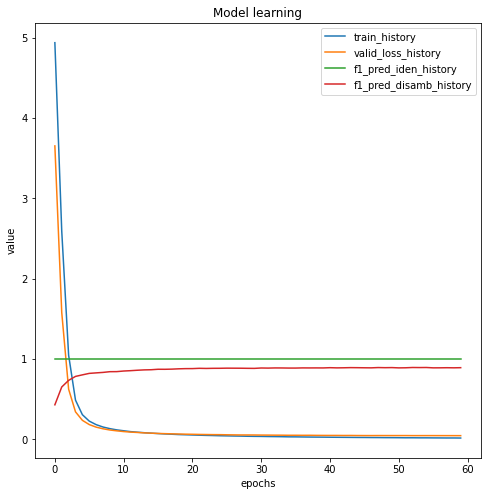

In [22]:
display_history(history)

## Predicate iden + diamb part

In [23]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['predicates_pad_id']) # !

Here, I won't use the position of the predicates:

In [24]:
from stud.modelsTests.model_pred_iden_dis_part.Model_pid_transformer_simple import PredIdenDisModel
import torch.optim as optim

final_model = PredIdenDisModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer = True,
    has_predicates_positions = False, # !
    has_pos_tags = False,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
history = {}

In [26]:
from stud.modelsTests.utils.Trainer_pid_transformer_simple import Trainer_pid_transformer_simple

trainer = Trainer_pid_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'pid_transformer_weights_en.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.560331
# Validation loss => 0.332557 | f1-score: arg_iden = 0.893626 arg_class = 0.204221 #
Epoch   1 => avg_loss: 0.338630
# Validation loss => 0.271426 | f1-score: arg_iden = 0.921992 arg_class = 0.374924 #
Epoch   2 => avg_loss: 0.277134
# Validation loss => 0.207981 | f1-score: arg_iden = 0.919540 arg_class = 0.537608 #
Epoch   3 => avg_loss: 0.221000
# Validation loss => 0.164825 | f1-score: arg_iden = 0.933831 arg_class = 0.616140 #
Epoch   4 => avg_loss: 0.187299
# Validation loss => 0.135011 | f1-score: arg_iden = 0.932698 arg_class = 0.680564 #
Epoch   5 => avg_loss: 0.154160
# Validation loss => 0.115029 | f1-score: arg_iden = 0.940481 arg_class = 0.731179 #
Epoch   6 => avg_loss: 0.134140
# Validation loss => 0.103851 | f1-score: arg_iden = 0.934272 arg_class = 0.750000 #
Epoch   7 => avg_loss: 0.119337
# Validation loss => 0.094638 | f1-score: arg_iden = 0.942001 arg_class = 0.772285 #
Epoch   8 => avg_loss: 0.106786
# Validation loss => 0.088412 | 

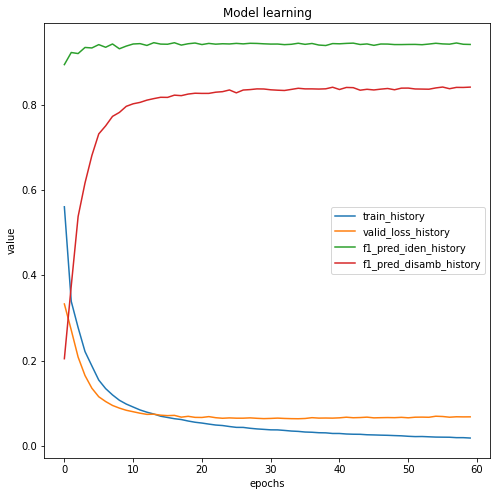

In [27]:
display_history(history)

# Spanish

## Predicate diamb part

In [28]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['predicates_pad_id']) # !

This first test will use the position of the predicates (so, doing only disambiguation)

In [29]:
from stud.modelsTests.model_pred_iden_dis_part.Model_pid_transformer_simple import PredIdenDisModel
import torch.optim as optim

final_model = PredIdenDisModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !!!
    loss_fn = loss_function,
    fine_tune_transformer = True,
    has_predicates_positions = True, # !
    has_pos_tags = False,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

In [30]:
history = {}

In [31]:
from stud.modelsTests.utils.Trainer_pid_transformer_simple import Trainer_pid_transformer_simple

trainer = Trainer_pid_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_es, dataloader_dev_es,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.6,
    save_path_name=os.path.join(model_dir_path, 'pd_transformer_weights_es.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.143176
# Validation loss => 0.128129 | f1-score: arg_iden = 0.999599 arg_class = 0.603849 #
----- Best value obtained, saving model -----
Epoch   1 => avg_loss: 0.125071
# Validation loss => 0.119572 | f1-score: arg_iden = 0.999599 arg_class = 0.625902 #
----- Best value obtained, saving model -----
Epoch   2 => avg_loss: 0.115830
# Validation loss => 0.117103 | f1-score: arg_iden = 0.999599 arg_class = 0.637530 #
----- Best value obtained, saving model -----
Epoch   3 => avg_loss: 0.106842
# Validation loss => 0.115106 | f1-score: arg_iden = 0.999599 arg_class = 0.637931 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.098154
# Validation loss => 0.112583 | f1-score: arg_iden = 0.999599 arg_class = 0.642743 #
----- Best value obtained, saving model -----
Epoch   5 => avg_loss: 0.093103
# Validation loss => 0.111509 | f1-score: arg_iden = 0.999599 arg_class = 0.648356 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss:

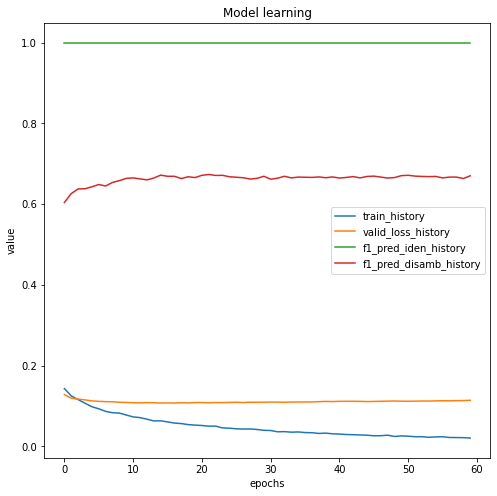

In [32]:
display_history(history)

## Predicate iden + diamb part

In [33]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['predicates_pad_id']) # !

Here, I won't use the position of the predicates:

In [34]:
from stud.modelsTests.model_pred_iden_dis_part.Model_pid_transformer_simple import PredIdenDisModel
import torch.optim as optim

final_model = PredIdenDisModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !!!
    loss_fn = loss_function,
    fine_tune_transformer = True,
    has_predicates_positions = False, # !
    has_pos_tags = False,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

In [35]:
history = {}

In [36]:
from stud.modelsTests.utils.Trainer_pid_transformer_simple import Trainer_pid_transformer_simple

trainer = Trainer_pid_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_es, dataloader_dev_es,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.6,
    save_path_name=os.path.join(model_dir_path, 'pid_transformer_weights_es.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.161341
# Validation loss => 0.146593 | f1-score: arg_iden = 0.964193 arg_class = 0.577716 #
Epoch   1 => avg_loss: 0.134683
# Validation loss => 0.135705 | f1-score: arg_iden = 0.971337 arg_class = 0.596512 #
Epoch   2 => avg_loss: 0.120976
# Validation loss => 0.128561 | f1-score: arg_iden = 0.975492 arg_class = 0.603857 #
----- Best value obtained, saving model -----
Epoch   3 => avg_loss: 0.108993
# Validation loss => 0.123943 | f1-score: arg_iden = 0.977947 arg_class = 0.621091 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.102875
# Validation loss => 0.122203 | f1-score: arg_iden = 0.978561 arg_class = 0.620317 #
Epoch   5 => avg_loss: 0.096604
# Validation loss => 0.119950 | f1-score: arg_iden = 0.979543 arg_class = 0.627758 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.089684
# Validation loss => 0.119659 | f1-score: arg_iden = 0.979567 arg_class = 0.629808 #
----- Best value obtained, saving model ---

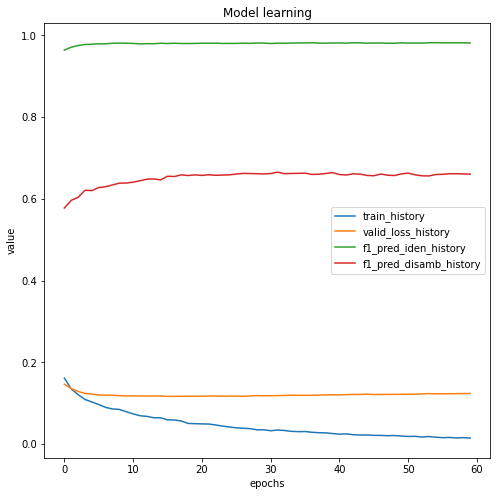

In [37]:
display_history(history)

# French

## Predicate diamb part

In [38]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['predicates_pad_id']) # !

This first test will use the position of the predicates (so, doing only disambiguation)

In [39]:
from stud.modelsTests.model_pred_iden_dis_part.Model_pid_transformer_simple import PredIdenDisModel
import torch.optim as optim

final_model = PredIdenDisModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !!!
    loss_fn = loss_function,
    fine_tune_transformer = True,
    has_predicates_positions = True, # !
    has_pos_tags = False,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

In [40]:
history = {}

In [41]:
from stud.modelsTests.utils.Trainer_pid_transformer_simple import Trainer_pid_transformer_simple

trainer = Trainer_pid_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_fr, dataloader_dev_fr,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.6,
    save_path_name=os.path.join(model_dir_path, 'pd_transformer_weights_fr.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.169611
# Validation loss => 0.138478 | f1-score: arg_iden = 0.999608 arg_class = 0.567737 #
Epoch   1 => avg_loss: 0.142701
# Validation loss => 0.129012 | f1-score: arg_iden = 0.999608 arg_class = 0.575568 #
Epoch   2 => avg_loss: 0.132138
# Validation loss => 0.123527 | f1-score: arg_iden = 0.999608 arg_class = 0.588097 #
Epoch   3 => avg_loss: 0.125636
# Validation loss => 0.120187 | f1-score: arg_iden = 0.999608 arg_class = 0.595145 #
Epoch   4 => avg_loss: 0.115378
# Validation loss => 0.118871 | f1-score: arg_iden = 0.999608 arg_class = 0.597494 #
Epoch   5 => avg_loss: 0.112014
# Validation loss => 0.118062 | f1-score: arg_iden = 0.999608 arg_class = 0.606108 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.108295
# Validation loss => 0.118433 | f1-score: arg_iden = 0.999608 arg_class = 0.604150 #
Epoch   7 => avg_loss: 0.098397
# Validation loss => 0.118067 | f1-score: arg_iden = 0.999608 arg_class = 0.606891 #
----- Best value o

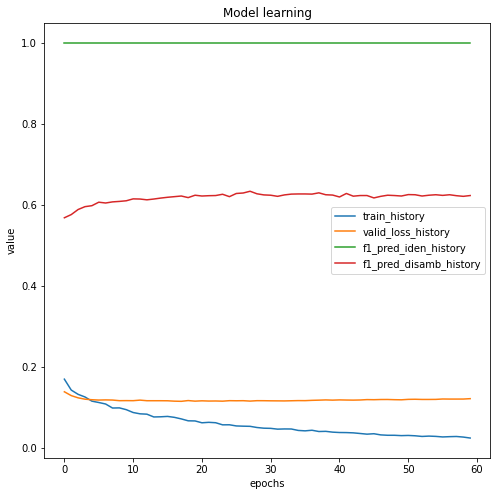

In [42]:
display_history(history)

## Predicate iden + diamb part

In [43]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['predicates_pad_id']) # !

Here, I won't use the position of the predicates:

In [44]:
from stud.modelsTests.model_pred_iden_dis_part.Model_pid_transformer_simple import PredIdenDisModel
import torch.optim as optim

final_model = PredIdenDisModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !!!
    loss_fn = loss_function,
    fine_tune_transformer = True,
    has_predicates_positions = False, # !
    has_pos_tags = False,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

In [45]:
history = {}

In [46]:
from stud.modelsTests.utils.Trainer_pid_transformer_simple import Trainer_pid_transformer_simple

trainer = Trainer_pid_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_fr, dataloader_dev_fr,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.6,
    save_path_name=os.path.join(model_dir_path, 'pid_transformer_weights_fr.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.198372
# Validation loss => 0.162577 | f1-score: arg_iden = 0.944652 arg_class = 0.518022 #
Epoch   1 => avg_loss: 0.170656
# Validation loss => 0.151130 | f1-score: arg_iden = 0.953529 arg_class = 0.536652 #
Epoch   2 => avg_loss: 0.153637
# Validation loss => 0.142837 | f1-score: arg_iden = 0.954287 arg_class = 0.552089 #
Epoch   3 => avg_loss: 0.138999
# Validation loss => 0.138119 | f1-score: arg_iden = 0.956830 arg_class = 0.565346 #
Epoch   4 => avg_loss: 0.130680
# Validation loss => 0.134802 | f1-score: arg_iden = 0.955312 arg_class = 0.567229 #
Epoch   5 => avg_loss: 0.121130
# Validation loss => 0.132076 | f1-score: arg_iden = 0.958260 arg_class = 0.571820 #
Epoch   6 => avg_loss: 0.115609
# Validation loss => 0.131072 | f1-score: arg_iden = 0.958464 arg_class = 0.575627 #
Epoch   7 => avg_loss: 0.109418
# Validation loss => 0.129948 | f1-score: arg_iden = 0.960079 arg_class = 0.580924 #
Epoch   8 => avg_loss: 0.108025
# Validation loss => 0.129631 | 

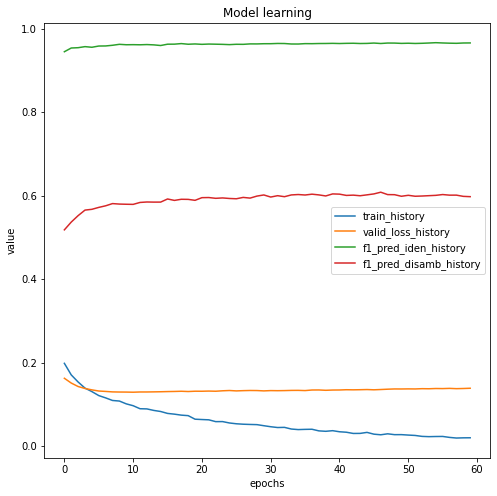

In [47]:
display_history(history)